In [1]:
%matplotlib notebook

import os
import numpy as np
from torchani.data._pyanitools import anidataloader
import matplotlib.pyplot as plt
import collections


```
The data is stored in a HDF5 file, each group usually holds information for multiple conformers for a molecule/chemical composition.
Information includes chemical composition, coordinates, GFN2-xTB & wB97x/6-31G* energies, ANI-1x & ANI-1ccx model energies for each conformers (both single model and ensemble averaged), ANI-1x & ANI-1ccx model atomic energies (both single model and ensemble averaged), and atom types assigned based on GAFF2 force field.
Atoms are given atom type "xx" if the compound/complex is unable to assign using Antechamber.
```

In [2]:
at_types = '''
c                Sp2 C carbonyl group 
c1               Sp C
c2               Sp2 C  
c3               Sp3 C
ca               Sp2 C in pure aromatic systems
cp               Head Sp2 C that connect two rings in biphenyl sys. 
cq               Head Sp2 C that connect two rings in biphenyl sys. identical to cp 
cc               Sp2 carbons in non-pure aromatic systems
cd               Sp2 carbons in non-pure aromatic systems, identical to cc
ce               Inner Sp2 carbons in conjugated systems
cf               Inner Sp2 carbons in conjugated systems, identical to ce
cg               Inner Sp carbons in conjugated systems
ch               Inner Sp carbons in conjugated systems, identical to cg
cx               Sp3 carbons in triangle systems
cy               Sp3 carbons in square systems
cu               Sp2 carbons in triangle systems
cv               Sp2 carbons in square systems
cz               Sp2 carbon in guanidine group
h1               H bonded to aliphatic carbon with 1 electrwd. group  
h2               H bonded to aliphatic carbon with 2 electrwd. group 
h3               H bonded to aliphatic carbon with 3 electrwd. group 
h4               H bonded to non-sp3 carbon with 1 electrwd. group 
h5               H bonded to non-sp3 carbon with 2 electrwd. group 
ha               H bonded to aromatic carbon  
hc               H bonded to aliphatic carbon without electrwd. group 
hn               H bonded to nitrogen atoms
ho               Hydroxyl group
hp               H bonded to phosphate 
hs               Hydrogen bonded to sulphur 
hw               Hydrogen in water 
hx               H bonded to C next to positively charged group  
n                Sp2 nitrogen in amide groups
n1               Sp N  
n2               aliphatic Sp2 N with two connected atoms 
n3               Sp3 N with three connected atoms
n4               Sp3 N with four connected atoms 
na               Sp2 N with three connected atoms 
nb               Sp2 N in pure aromatic systems 
nc               Sp2 N in non-pure aromatic systems
nd               Sp2 N in non-pure aromatic systems, identical to nc
ne               Inner Sp2 N in conjugated systems
nf               Inner Sp2 N in conjugated systems, identical to ne
nh               Amine N connected one or more aromatic rings 
no               Nitro N  
ns               amine N, with 1 attached hydrogen atom
nt               amine N, with 2 attached hydrogen atoms
nx               like n4, but only has one hydrogen atom
ny               like n4, but only has two hydrogen atoms
nz               like n4, but only has three three hydrogen atoms
n+               NH4+
nu               like nh, but only has one attached hydrogen atom
nv               like nh, but only has two attached hydrogen atoms
n7               like n3, but only has one attached hydrogen atom 
n8               like n3, but only has two attached hydrogen atoms
n9               NH3
ni               like n in RG3 
nj               like n in RG4
nk               like n4/nx/ny in RG3 
nl               like n4/nx/ny in RG4
nm               like nh in RG3 
nn               like nh in RG4
np               like n3 in RG3 
nq               like n3 in RG4
n5               like n7 in RG3 
n6               like n7 in RG4
o                Oxygen with one connected atom
oh               Oxygen in hydroxyl group
op               
oq               
os               Ether and ester oxygen
ow               Oxygen in water 
'''


In [3]:
dict_ats = collections.defaultdict(list)

for data in anidataloader('../dataset/gaff_typing_ani_md_wb97x_dz_xtb_ani_aes.h5'):
    formula = data['path'].split('/')[-1]
    species = data['species']
    wb97x_dz_energy = data['wb97x_dz_energy']
    ani1x_atom_energy = data['ani1x_atom_energy']
    # ani1ccx_atom_energy = data['ani1ccx_atom_energy']
    gaff_types = data['gaff_types']
    for i in range(len(wb97x_dz_energy)): # loop through conformers
        for atype, ani1x_ae in zip(gaff_types[i], ani1x_atom_energy[i]): # loop through atoms
            dict_ats[atype.decode("utf-8")].append(ani1x_ae[8]) # use only the ensemble averaged atomic energy



In [5]:
print('atom type | number of values')
for k, v in sorted(dict_ats.items()):
    print("%s \t %d" % (k, len(v)))

# remove atom types for identical environment used in antechamber
dict_ats['cp'].extend(dict_ats['cq'])
del dict_ats['cq']
dict_ats['cc'].extend(dict_ats['cd'])
del dict_ats['cd']
dict_ats['ce'].extend(dict_ats['cf'])
del dict_ats['cf']
dict_ats['cg'].extend(dict_ats['ch'])
del dict_ats['ch']

dict_ats['n3'].extend(dict_ats['n5'] + dict_ats['n6'] + dict_ats['n7'] + dict_ats['n8'] \
                      + dict_ats['np'] + dict_ats['nq'])
del dict_ats['n5']
del dict_ats['n6']
del dict_ats['n7']
del dict_ats['n8']
del dict_ats['np']
del dict_ats['nq']
dict_ats['n4'].extend(dict_ats['nx'] + dict_ats['ny'] + dict_ats['nz'] + dict_ats['nk'] + dict_ats['nl'])
del dict_ats['nx']
del dict_ats['ny']
del dict_ats['nz']
del dict_ats['nk']
del dict_ats['nl']
dict_ats['nc'].extend(dict_ats['nd'])
del dict_ats['nd']
dict_ats['ne'].extend(dict_ats['nf'])
del dict_ats['nf']
dict_ats['nh'].extend(dict_ats['nu'] + dict_ats['nv'] + dict_ats['nm'] + dict_ats['nn'])
del dict_ats['nu']
del dict_ats['nv']
del dict_ats['nm']
del dict_ats['nn']
dict_ats['ns'].extend(dict_ats['nt'])
del dict_ats['nt']

# generate a simplified atom typing based on description in GAFF2
dict_sats = collections.defaultdict(list)
dict_sats['Csp1'].extend(dict_ats['c1'] + dict_ats['cg'])
dict_sats['Csp2'].extend(dict_ats['c'] + dict_ats['c2'] + dict_ats['cc'] + dict_ats['cu'] + dict_ats['cv'] \
                         + dict_ats['cz'])
dict_sats['Csp3'].extend(dict_ats['c3'] + dict_ats['cx'] + dict_ats['cy'])
dict_sats['Caro'].extend(dict_ats['ca'] + dict_ats['cp'] + dict_ats['ce'])

dict_sats['Nsp1'].extend(dict_ats['n1'])
dict_sats['Nsp2'].extend(dict_ats['n'] + dict_ats['n2'] + dict_ats['na'] + dict_ats['nc'])
dict_sats['Nsp3'].extend(dict_ats['n3'] + dict_ats['n4'] + dict_ats['nh'] + dict_ats['ns'] + dict_ats['n9'])
dict_sats['Naro'].extend(dict_ats['nb'] + dict_ats['ne'])
dict_sats['Nnitro'].extend(dict_ats['no'])
dict_sats['N+'].extend(dict_ats['n+'])

print('-----------------------------')
print('atom type | number of values')
for k, v in sorted(dict_ats.items()):
    print("%s \t %d" % (k, len(v)))

print('-----------------------------')
print('atom type | number of values')
for k, v in sorted(dict_sats.items()):
    print("%s \t %d" % (k, len(v)))


atom type | number of values
c2 	 505
c3 	 47174
cc 	 9
ce 	 34
cg 	 0
cp 	 0
h1 	 18762
h2 	 47
h3 	 118
h5 	 10
ha 	 317
hc 	 39854
hn 	 7168
ho 	 2432
n2 	 7
n3 	 8295
n4 	 0
na 	 3
nc 	 3
ne 	 0
nh 	 10
oh 	 2432
os 	 7423
-----------------------------
atom type | number of values
c 	 0
c1 	 0
c2 	 505
c3 	 47174
ca 	 0
cc 	 9
ce 	 34
cg 	 0
cp 	 0
cu 	 0
cv 	 0
cx 	 0
cy 	 0
cz 	 0
h1 	 18762
h2 	 47
h3 	 118
h5 	 10
ha 	 317
hc 	 39854
hn 	 7168
ho 	 2432
n 	 0
n+ 	 0
n1 	 0
n2 	 7
n3 	 8295
n4 	 0
n9 	 0
na 	 3
nb 	 0
nc 	 3
ne 	 0
nh 	 10
no 	 0
ns 	 0
oh 	 2432
os 	 7423
-----------------------------
atom type | number of values
Caro 	 34
Csp1 	 0
Csp2 	 514
Csp3 	 47174
N+ 	 0
Naro 	 0
Nnitro 	 0
Nsp1 	 0
Nsp2 	 13
Nsp3 	 8305


<IPython.core.display.Javascript object>


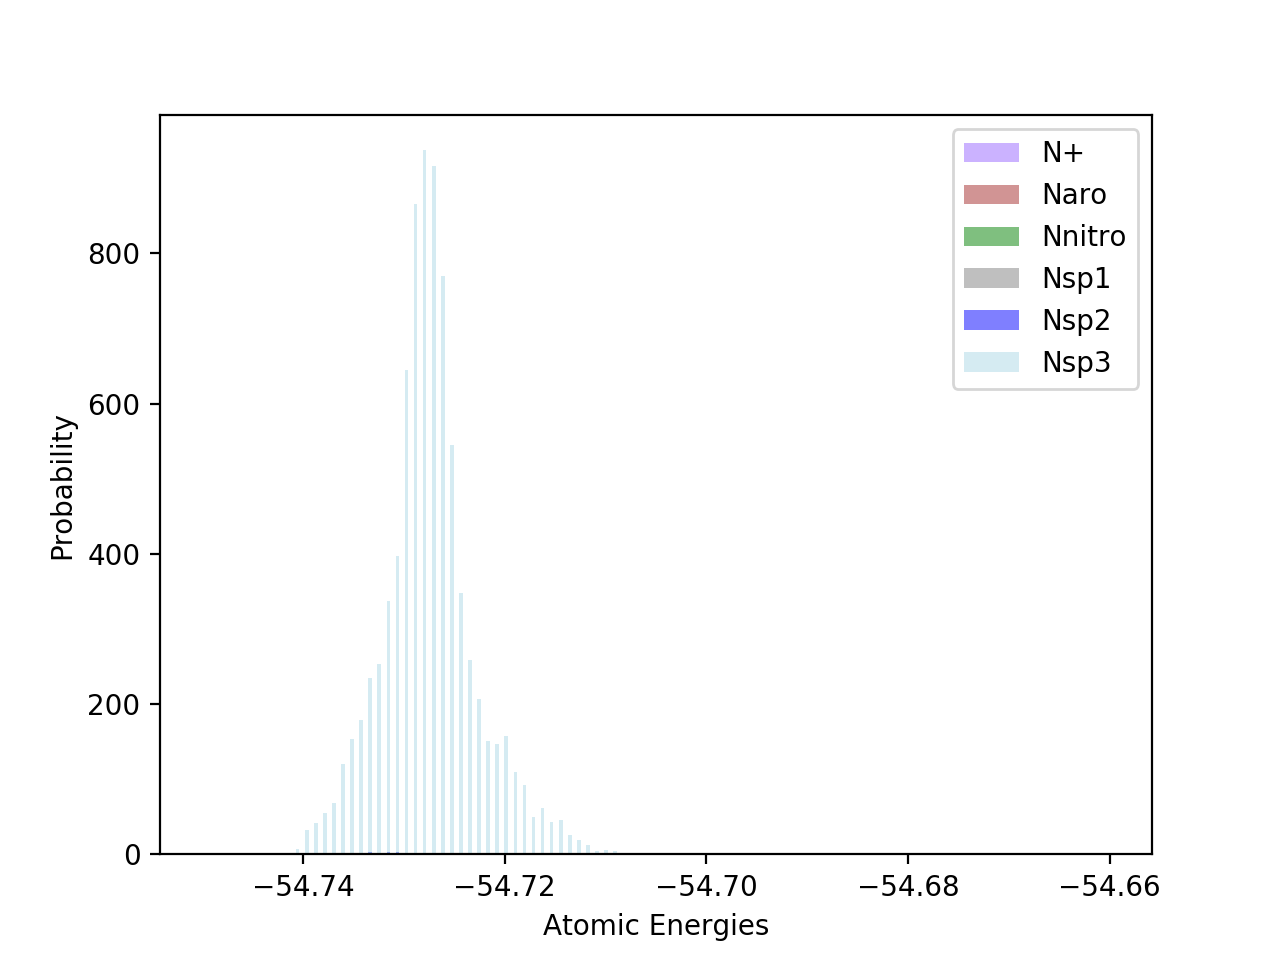

In [16]:
# plt.clf()
fig = plt.figure()
ax = plt.subplot()
box = ax.get_position()
# plt.axis([-2, 50, -2, 50])
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.xlabel('Atomic Energies')
plt.ylabel('Probability')


colors_dict = {'Nsp1':'#808080', 'Nsp2':'#0000FF', 'Nsp3':'#ADD8E6', 'Naro':'#A52A2A', 'Nnitro':'#008000', \
               'N+':'#9966FF'}
               

for k, v in sorted(dict_sats.items()):
    if k.startswith('N'):
        # print(k, len(v))
        n, bins, patches = plt.hist(v, bins=100, range=(-54.75, -54.66), rwidth=0.4, density=False, \
                                    facecolor=colors_dict[k], alpha=0.5, label=(k))

ax.legend()
plt.show()


<IPython.core.display.Javascript object>


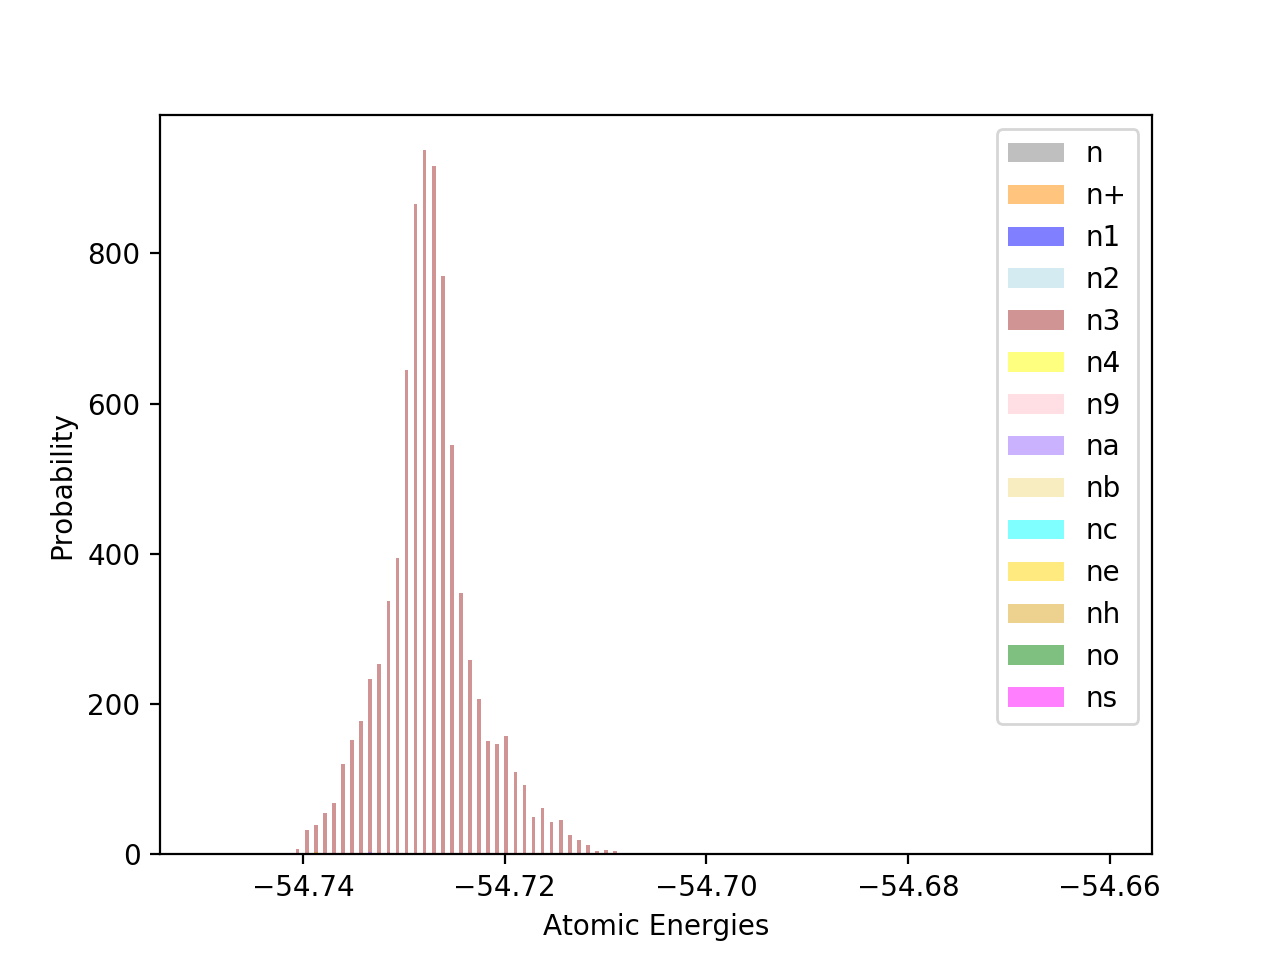

In [17]:
fig = plt.figure()
ax = plt.subplot()
box = ax.get_position()
# plt.axis([-2, 50, -2, 50])
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.xlabel('Atomic Energies')
plt.ylabel('Probability')


colors_dict = {'n':'#808080', 'n1':'#0000FF', 'n2':'#ADD8E6', 'n3':'#A52A2A', 'n4':'#FFFF00', \
               'na':'#9966FF', 'nb':'#F0DC82', 'nc':'#00FFFF', 'ne':'#FFD700', 'nh':'#DAA520', \
               'nj':'#D3D3D3', 'no':'#008000', 'ns':'#FF00FF', 'n+':'#FF8C00', 'n9':'#FFC0CB'}
               

for k, v in sorted(dict_ats.items()):
    if k.startswith('n'):
        # print(k, len(v))
        n, bins, patches = plt.hist(v, bins=100, range=(-54.75, -54.66), rwidth=0.4, density=False, \
                                    facecolor=colors_dict[k], alpha=0.5, label=(k))

ax.legend()
plt.show()


<IPython.core.display.Javascript object>


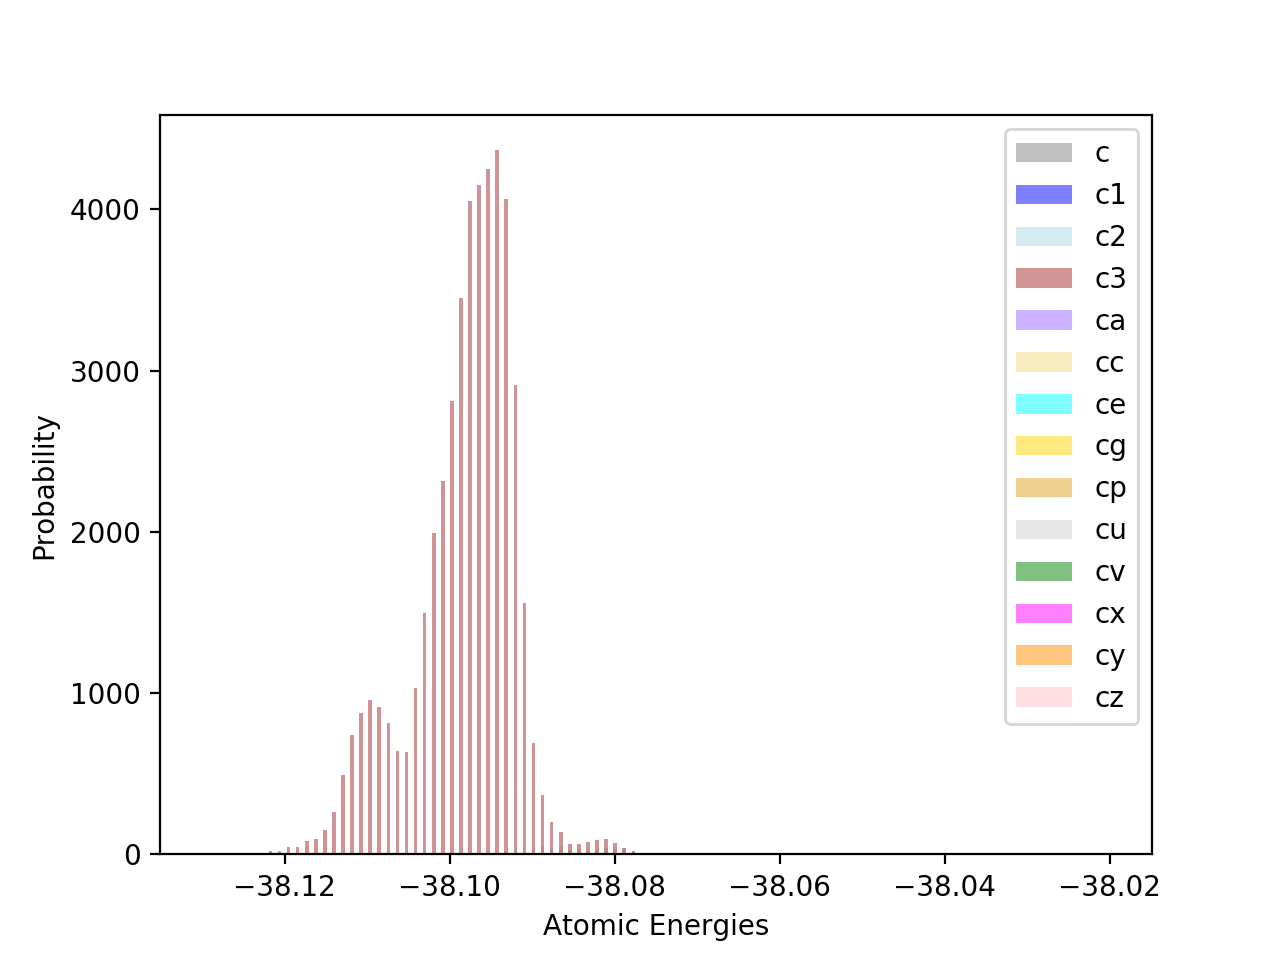

In [18]:
fig = plt.figure()
ax = plt.subplot()
box = ax.get_position()
# plt.axis([-2, 50, -2, 50])
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.xlabel('Atomic Energies')
plt.ylabel('Probability')

colors_dict = {'c':'#808080', 'c1':'#0000FF', 'c2':'#ADD8E6', 'c3':'#A52A2A', \
               'ca':'#9966FF', 'cc':'#F0DC82', 'ce':'#00FFFF', 'cg':'#FFD700', \
               'cp':'#DAA520', 'cu':'#D3D3D3', 'cv':'#008000', 'cx':'#FF00FF', \
               'cy':'#FF8C00', 'cz':'#FFC0CB'}

for k, v in sorted(dict_ats.items()):
    if k.startswith('c'):
        n, bins, patches = plt.hist(v, bins=100, range=(-38.13, -38.02), rwidth=0.4, density=False, \
                                    facecolor=colors_dict[k], alpha=0.5, label=(k))


ax.legend()
plt.show()


<IPython.core.display.Javascript object>


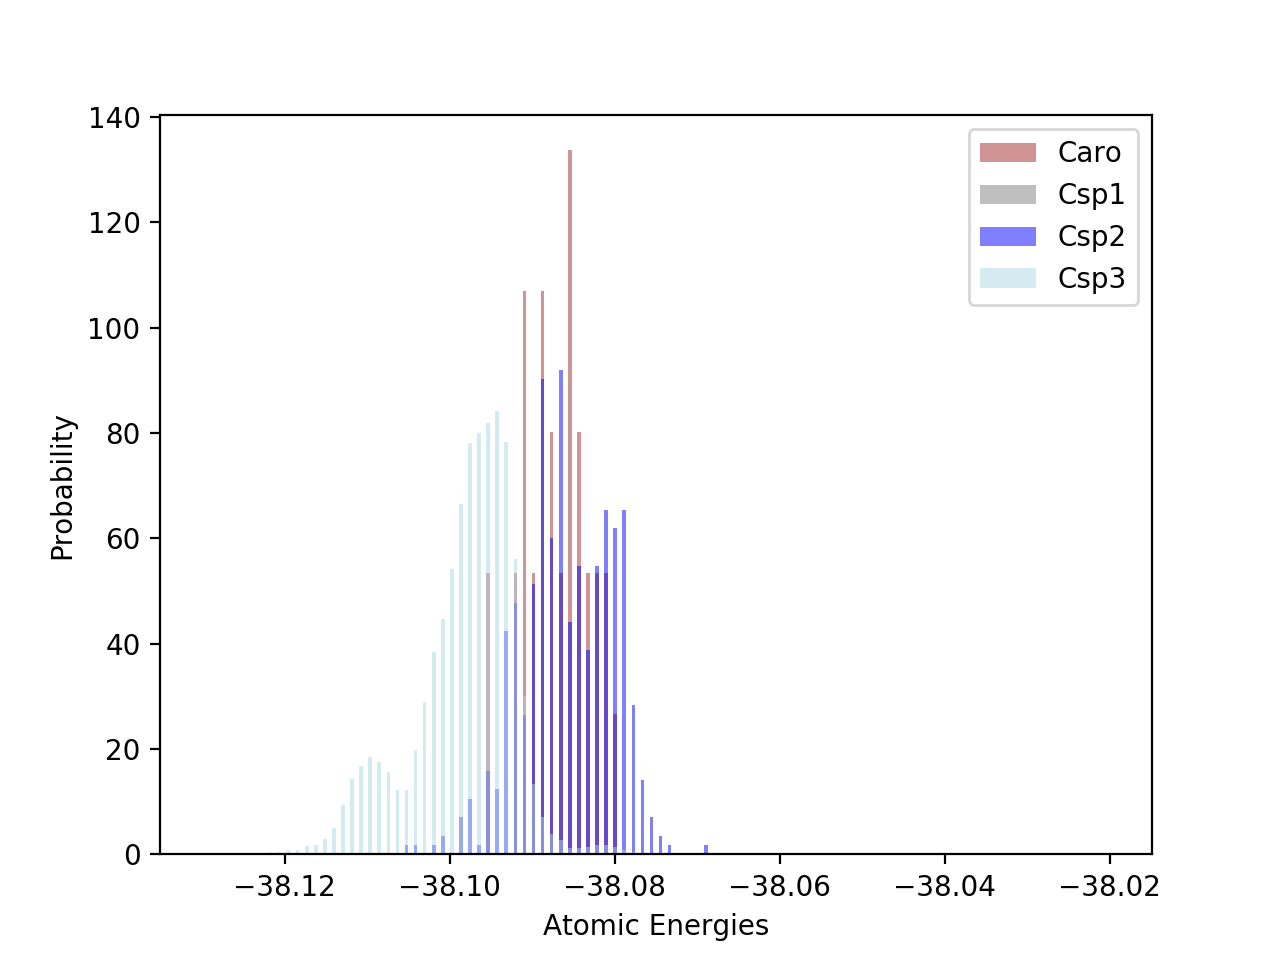

In [20]:
# plt.clf()
fig = plt.figure()
ax = plt.subplot()
box = ax.get_position()
# plt.axis([-2, 50, -2, 50])
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.xlabel('Atomic Energies')
plt.ylabel('Probability')


colors_dict = {'Csp1':'#808080', 'Csp2':'#0000FF', 'Csp3':'#ADD8E6', 'Caro':'#A52A2A'}
               

for k, v in sorted(dict_sats.items()):
    if k.startswith('C'):
        # print(k, len(v))
        n, bins, patches = plt.hist(v, bins=100, range=(-38.13, -38.02), rwidth=0.4, density=True, \
                                    facecolor=colors_dict[k], alpha=0.5, label=(k))

ax.legend()
plt.show()


<IPython.core.display.Javascript object>


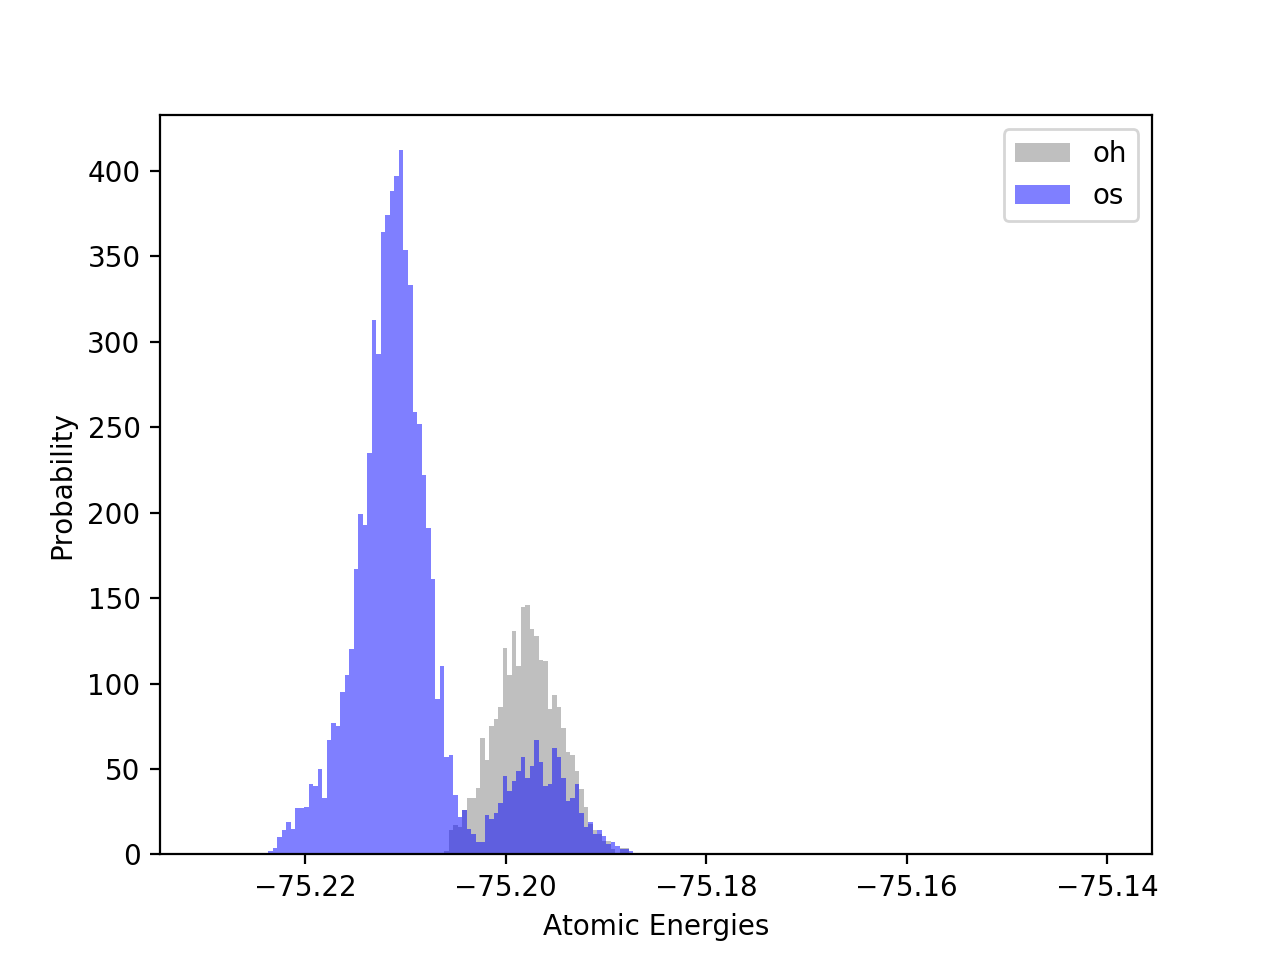

In [14]:
fig = plt.figure()
ax = plt.subplot()
box = ax.get_position()
# plt.axis([-2, 50, -2, 50])
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.xlabel('Atomic Energies')
plt.ylabel('Probability')

# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
colors = ['#808080', '#0000FF', '#ADD8E6', '#A52A2A', '#9966FF', '#F0DC82', '#00FFFF', \
          '#FFD700', '#DAA520', '#D3D3D3', '#008000', '#FF00FF', '#FF8C00', '#FFC0CB', \
          '#FF0000', '#EE82EE']
count = 0
for k, v in sorted(dict_ats.items()):
    if k.startswith('o'):
        n, bins, patches = plt.hist(v, bins=200, range=(-75.23, -75.14), density=False, \
                                    facecolor=colors[count % len(colors)], alpha=0.5, label=(k))
        count += 1

ax.legend()
plt.show()


<IPython.core.display.Javascript object>


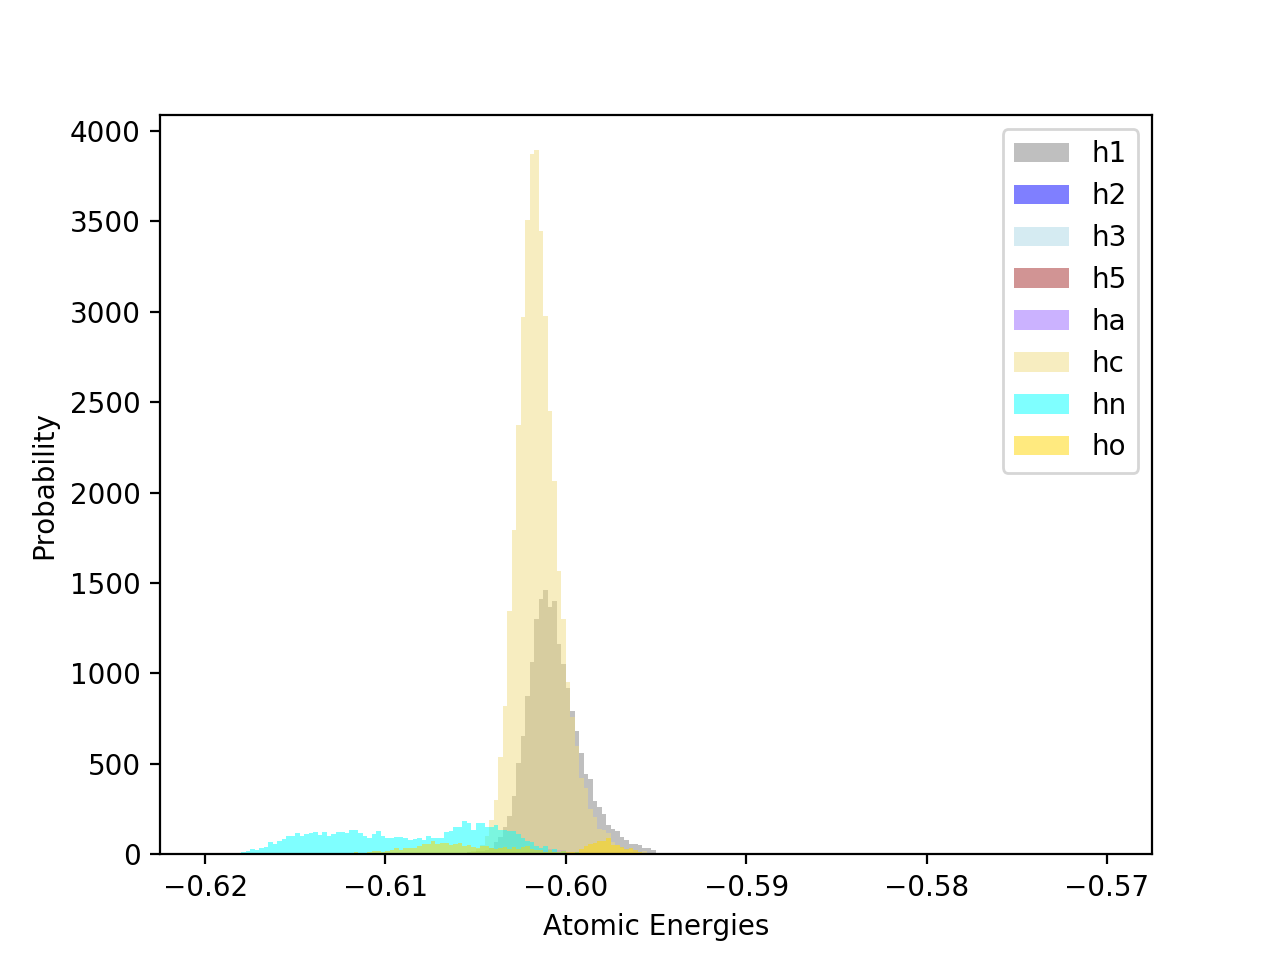

In [15]:
fig = plt.figure()
ax = plt.subplot()
box = ax.get_position()
# plt.axis([-2, 50, -2, 50])
# ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
plt.xlabel('Atomic Energies')
plt.ylabel('Probability')

# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
colors = ['#808080', '#0000FF', '#ADD8E6', '#A52A2A', '#9966FF', '#F0DC82', '#00FFFF', \
          '#FFD700', '#DAA520', '#D3D3D3', '#008000', '#FF00FF', '#FF8C00', '#FFC0CB', \
          '#FF0000', '#EE82EE']
count = 0

for k, v in sorted(dict_ats.items()):
    if k.startswith('h'):
        n, bins, patches = plt.hist(v, bins=200, range=(-0.62, -0.57), density=False,\
                                    facecolor=colors[count % len(colors)], alpha=0.5, label=(k))
        count += 1

ax.legend()
plt.show()
